# PQCs for evaluating $Q$-values

#### Imports

In [1]:
#General imports
import numpy as np
import matplotlib.pyplot as plt

#Operator Imports
from qiskit.aqua.operators import Z, I, StateFn, CircuitStateFn, SummedOp
from qiskit.aqua.operators.gradients import Gradient, NaturalGradient, QFI, Hessian

#Circuit imports
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector, ParameterExpression

#Qiskit imports
import qiskit as qk
from qiskit.circuit.library import TwoLocal
import qiskit_machine_learning as qkml
from qiskit.utils import QuantumInstance

# Fix seed for reproducibility
seed = 42
np.random.seed(42)

### Function declarations

##### `encoding_circuit`  

Function to load classical data (in our case the state/action of the agent and of its environment).

In [2]:
def encoding_circuit(inputs, num_qubits = 4, gate = 'rx', *args):
    """
    Encode classical input data on a quantum circuit. 
    
    To be used inside the `parametrized_circuit` function. 
    
    Args
    -------
    
    Return
    -------
    
    
    TODO:
    1. Add choice of encoding gate: ry, rz, or rx.
    """
    
    qc = qk.QuantumCircuit(num_qubits)
    
    # Encode data with a RX rotation
    for i, data in enumerate(inputs): 
        qc.rx(inputs[i], i)
        
    return qc

#### `parametrized_circuit`  

Create the variational circuit (the PQC) by composing the encoding and a variational ansatze. It is possible to use data reuploading –loading the classical data multiple times throughout the circuit– to make the circuit more exxpressive and powerful.

In [3]:
def parametrized_circuit(inputs, num_qubits = 4, reuploading = False, reps = 2, insert_barriers = True, meas = False):
    """
    Create the Parameterized Quantum Circuit (PQC) for estimating Q-values.
    It is the same reported in arXiv:2104.15084 (Skolik et al.).
    
    Args
    -------
    
    Return
    -------
    """
    
    qr = qk.QuantumRegister(num_qubits, 'qr')
    qc = qk.QuantumCircuit(qr)
    
    if meas:
        qr = qk.QuantumRegister(num_qubits, 'qr')
        cr = qk.ClassicalRegister(num_qubits, 'cr')
        qc = qk.QuantumCircuit(qr,cr)
    
    
    if not reuploading:
        
        # Define a vector containg Inputs as parameters (*not* to be optimized)
        inputs = qk.circuit.ParameterVector('x', num_qubits)
        
        # Encode classical input data
        qc.compose(encoding_circuit(inputs, num_qubits = num_qubits), inplace = True)
        if insert_barriers: qc.barrier()
        
        # Variational circuit
        qc.compose(TwoLocal(num_qubits, ['ry', 'rz'], 'cx', 'circular', 
               reps=reps, insert_barriers= insert_barriers, 
               skip_final_rotation_layer = True), inplace = True)
        if insert_barriers: qc.barrier()
        
        # Add final measurements
        if meas: qc.measure(qr,cr)
        
    elif reuploading:
        
        # Define a vector containg Inputs as parameters (*not* to be optimized)
        inputs = qk.circuit.ParameterVector('x', num_qubits)
        
        # Define a vector containng variational parameters
        θ = qk.circuit.ParameterVector('θ', 2 * num_qubits * reps)
        
        # Iterate for a number of repetitions
        for rep in range(reps):

            # Encode classical input data
            qc.compose(encoding_circuit(inputs, num_qubits = num_qubits), inplace = True)
            if insert_barriers: qc.barrier()
                
            # Variational circuit (does the same as TwoLocal from Qiskit)
            for qubit in range(num_qubits):
                qc.ry(θ[qubit + 2*num_qubits*(rep)], qubit)
                qc.rz(θ[qubit + 2*num_qubits*(rep) + num_qubits], qubit)
            if insert_barriers: qc.barrier()
                
            # Add entanglers (this code is for a circular entangler)
            qc.cx(qr[-1], qr[0])
            for qubit in range(num_qubits-1):
                qc.cx(qr[qubit], qr[qubit+1])
            if insert_barriers: qc.barrier()
                        
        # (Optional) Add final measurements
        if meas: qc.measure(qr,cr)
        
    return qc

#### The Parametrized Quantum Circuit (PQC)

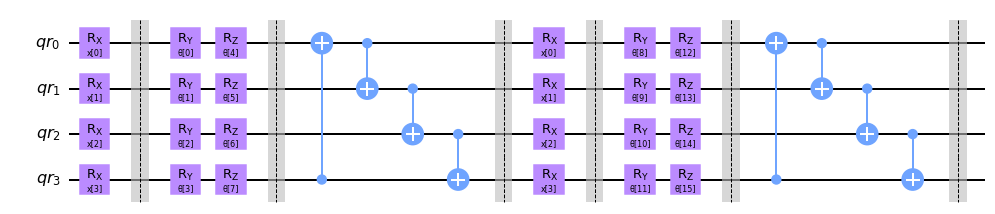

In [4]:
# Select the number of qubits
num_qubits = 4

# Generate some random inputs
inputs = np.random.rand(num_qubits)

# Generate the Parametrized Quantum Circuit (note the flag reuploading)
qc = parametrized_circuit(inputs, num_qubits = 4, reuploading = True)
qc.draw()

#### Binding parameters to some actual value (number)

Here's how it's done.

Random parameters
> Random inputs: [0.156 0.156 0.058 0.866]
> Random weights: [0.601 0.708 0.021 0.97  0.832 0.212 0.182 0.183 0.304 0.525 0.432 0.291
 0.612 0.139 0.292 0.366]
Circuit with randomly initialized parameters


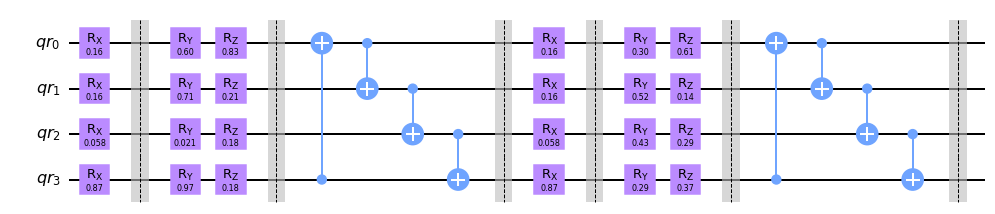

In [5]:
# Take the free variational parameters of the quantum circuit and put them in a list
params = list(qc.parameters)

# Generate some random values for the parameters
rand_params = np.round(np.random.rand(len(params)),3).astype('float16')
print("Random parameters")
print("> Random inputs:", rand_params[:4])
print("> Random weights:", rand_params[4:])

# Create a dictionary biding a parameter of the circuit to a random number just created
value_dict = {params[i]: rand_params[i] for i in range(qc.num_parameters)}

# Assign the values in the circuit
print("Circuit with randomly initialized parameters")
qca = qc.assign_parameters(value_dict)
qca.draw()

#### Separate the inputs (not trainabile) from the weights (to bo optimized)

In [6]:
X = list(qc.parameters)[:4]
params = list(qc.parameters)[4:]

print("Inputs as parameters:\n", X)
print("")
print("Trainable parameters (weights):\n", params)

Inputs as parameters:
 [ParameterVectorElement(x[0]), ParameterVectorElement(x[1]), ParameterVectorElement(x[2]), ParameterVectorElement(x[3])]

Trainable parameters (weights):
 [ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7]), ParameterVectorElement(θ[8]), ParameterVectorElement(θ[9]), ParameterVectorElement(θ[10]), ParameterVectorElement(θ[11]), ParameterVectorElement(θ[12]), ParameterVectorElement(θ[13]), ParameterVectorElement(θ[14]), ParameterVectorElement(θ[15])]


### Evaluate Gradients 

In this part we use the variational quantum circuit just introduced, and we evaluate the gradients wrt the parameters. 
That is we have an observable $O$ and we evaluate the derivative of such observable evaluated on the parametrized quantum state created by the variational circuit, that is:

$$
\frac{\partial \langle O \rangle_{\boldsymbol{\theta}}}{\partial \boldsymbol{\theta}} = \frac{\partial}{\partial \boldsymbol{\theta}}\langle \psi_\boldsymbol{\theta} | O |\psi_\boldsymbol{\theta}\rangle
$$

where $\boldsymbol{\theta}$ denotes the parameters in the PQC created above. There are multiple ways to do this, one of them being the *parameter shift role*.

In [7]:
# Define the Observable
O = -1 * Z ^ I ^ I ^ I
#  Examples of possible observavles
# O = 0.5 * Z -1 * X # scalar coefficients can be used
# O = X ^ I ^ Y      # '^' indicates the tensor product of observables acting on different qubits

# Combine the Observable and the variational state into an Expectation Value Operator
op = ~StateFn(O) @ CircuitStateFn(primitive=qc, coeff=1.)
print(op)

ComposedOp([
  OperatorMeasurement(-1.0 * ZIII),
  CircuitStateFn(
        ┌──────────┐ ░ ┌──────────┐┌──────────┐ ░ ┌───┐                ░ »
  qr_0: ┤ RX(x[0]) ├─░─┤ RY(θ[0]) ├┤ RZ(θ[4]) ├─░─┤ X ├──■─────────────░─»
        ├──────────┤ ░ ├──────────┤├──────────┤ ░ └─┬─┘┌─┴─┐           ░ »
  qr_1: ┤ RX(x[1]) ├─░─┤ RY(θ[1]) ├┤ RZ(θ[5]) ├─░───┼──┤ X ├──■────────░─»
        ├──────────┤ ░ ├──────────┤├──────────┤ ░   │  └───┘┌─┴─┐      ░ »
  qr_2: ┤ RX(x[2]) ├─░─┤ RY(θ[2]) ├┤ RZ(θ[6]) ├─░───┼───────┤ X ├──■───░─»
        ├──────────┤ ░ ├──────────┤├──────────┤ ░   │       └───┘┌─┴─┐ ░ »
  qr_3: ┤ RX(x[3]) ├─░─┤ RY(θ[3]) ├┤ RZ(θ[7]) ├─░───■────────────┤ X ├─░─»
        └──────────┘ ░ └──────────┘└──────────┘ ░                └───┘ ░ »
  «      ┌──────────┐ ░  ┌──────────┐┌───────────┐ ░ ┌───┐                ░ 
  «qr_0: ┤ RX(x[0]) ├─░──┤ RY(θ[8]) ├┤ RZ(θ[12]) ├─░─┤ X ├──■─────────────░─
  «      ├──────────┤ ░  ├──────────┤├───────────┤ ░ └─┬─┘┌─┴─┐           ░ 
  «qr_1: ┤ RX(x[1]) ├─░──┤ 

/opt/anaconda3/envs/IBMHack/lib/python3.8/site-packages/qiskit/aqua/operators/operator_base.py:46: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_package('aqua.operators', 'qiskit.opflow', 'qiskit-terra')


In [8]:
# Convert the Expectation Value into an operator corresponding to the gradient w.r.t. the state parameters using
# the parameter shift method.
state_grad = Gradient(grad_method='param_shift').convert(operator=op, params=params)

# Print the operator corresponding to the gradient
print(state_grad)

# Assign values to the parameters and evaluate the gradient
state_grad_result = state_grad.assign_parameters(value_dict).eval()
print('State gradient computed with parameter shift', state_grad_result)

ListOp([
  -1.0 * SummedOp([
    0.5 * ComposedOp([
      OperatorMeasurement(ZIII),
      CircuitStateFn(
            ┌──────────┐ ░ ┌────────────────────────────┐┌──────────┐ ░ ┌───┐     »
      qr_0: ┤ RX(x[0]) ├─░─┤ RY(θ[0] + 1.5707963267949) ├┤ RZ(θ[4]) ├─░─┤ X ├──■──»
            ├──────────┤ ░ └────────┬──────────┬────────┘├──────────┤ ░ └─┬─┘┌─┴─┐»
      qr_1: ┤ RX(x[1]) ├─░──────────┤ RY(θ[1]) ├─────────┤ RZ(θ[5]) ├─░───┼──┤ X ├»
            ├──────────┤ ░          ├──────────┤         ├──────────┤ ░   │  └───┘»
      qr_2: ┤ RX(x[2]) ├─░──────────┤ RY(θ[2]) ├─────────┤ RZ(θ[6]) ├─░───┼───────»
            ├──────────┤ ░          ├──────────┤         ├──────────┤ ░   │       »
      qr_3: ┤ RX(x[3]) ├─░──────────┤ RY(θ[3]) ├─────────┤ RZ(θ[7]) ├─░───■───────»
            └──────────┘ ░          └──────────┘         └──────────┘ ░           »
      «                 ░ ┌──────────┐ ░  ┌──────────┐┌───────────┐ ░ ┌───┐          »
      «qr_0: ───────────░─┤ RX(x[0]) ├─░──┤ RY(θ[8

State gradient computed with parameter shift [(0.14804952437782282-1.4e-17j), (0.050333151706137245-4.1499999999999996e-17j), (0.09113013016313064+1.0999999999999997e-17j), (0.3483406285968647-1.18e-16j), (-0.10120979815422156+2.8e-17j), (0.03245665778757546+0j), (0.005546685879249932+4.2e-17j), (0.03452506258722883-2.8e-17j), (0.46855836724136124-1.55e-17j), (0.13797092297039482-4.1499999999999996e-17j), (0.15026494064052198+1.05e-17j), (-1.3877787807814457e-17-2.799999999999999e-17j), (-6.938893903907228e-18-1.3999999999999993e-17j), (-6.938893903907228e-18+9.75e-17j), (-4.163336342344337e-17+4.2e-17j), 0j]


Initial random parameters

In [9]:
print("Initial random parameters")
print(rand_params[4:])

print("\nGradients of the parameters")
print(np.real(np.round(state_grad_result,3)))

print("\nUpdated parameters")
print(np.real(np.round(rand_params[4:] + state_grad_result, 3)))

Initial random parameters
[0.601 0.708 0.021 0.97  0.832 0.212 0.182 0.183 0.304 0.525 0.432 0.291
 0.612 0.139 0.292 0.366]

Gradients of the parameters
[ 0.148  0.05   0.091  0.348 -0.101  0.032  0.006  0.035  0.469  0.138
  0.15  -0.    -0.    -0.    -0.     0.   ]

Updated parameters
[0.749 0.758 0.112 1.319 0.731 0.244 0.188 0.218 0.773 0.663 0.582 0.291
 0.612 0.139 0.292 0.366]


### Use in a Variational Quantum Algorithm

In [10]:
# Execution Imports
from qiskit import Aer

# Algorithm Imports
from qiskit.aqua.algorithms import VQE
from qiskit.aqua.components.optimizers import CG, ADAM, L_BFGS_B

from qiskit.aqua.operators import I, Z
from qiskit.circuit import QuantumCircuit, ParameterVector
from scipy.optimize import minimize

In [11]:
# Assign some random values to the inputs
num_qubits = 4
# Generate random values
random_x = np.random.rand(num_qubits)
# Create a dictionary to map inputs parameters X to actual numbers
x_dict = {X[i]: random_x[i] for i in range(len(random_x))}
# Create a new circuit (wx = "with x"), with actual values in place of the inputs
qc_wx = qc.assign_parameters(x_dict)


grad = Gradient(grad_method='param_shift').convert(operator=op, params=params)

qi_sv = qk.aqua.QuantumInstance(Aer.get_backend('statevector_simulator'),
                        shots=1,
                        seed_simulator=seed,
                        seed_transpiler=seed)

#Conjugate Gradient algorithm
optimizer = L_BFGS_B()

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

# Gradient callable
vqe = VQE(O, qc_wx, optimizer=optimizer, gradient=grad, callback=store_intermediate_result)

result = vqe.run(qi_sv)

import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(result)

print('\nOptimized Expectation Value:', result['optimal_value'])

/opt/anaconda3/envs/IBMHack/lib/python3.8/site-packages/qiskit/aqua/quantum_instance.py:135: DeprecationWarning: The class qiskit.aqua.QuantumInstance is deprecated. It was moved/refactored to qiskit.utils.QuantumInstance (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_class('aqua.QuantumInstance',
/opt/anaconda3/envs/IBMHack/lib/python3.8/site-packages/qiskit/aqua/components/optimizers/optimizer.py:49: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_package('aqua.components.optimizers',
/opt/anaconda3/envs/IBMHack/lib/python3.8/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:70: DeprecationWarning: The class qiskit.aqua.algorithms.VQAlgorithm is deprecated. It was move

{   'cost_function_evals': 1003,
    'eigenstate': array([ 2.22214036e-01+3.34907375e-01j, -2.56320174e-01-2.61948581e-01j,
        3.13503808e-01-1.73940592e-01j,  3.92580968e-01+3.32330733e-02j,
        6.24816646e-02-3.01636217e-01j, -6.25728432e-02-3.42663023e-01j,
       -3.13641847e-01+1.32046007e-01j,  2.72812263e-01-1.17965128e-01j,
        7.28453136e-04-4.99054551e-04j,  1.31161278e-04+7.38069826e-04j,
       -3.94269203e-04-7.76283588e-04j, -5.78326237e-04-4.42159849e-04j,
       -2.62562554e-04+9.76590319e-04j, -3.61007850e-04+5.27560858e-04j,
        6.83749315e-04-2.98130797e-04j, -8.13999778e-04-2.20248353e-04j]),
    'eigenvalue': (-0.9999893430086159+0j),
    'optimal_parameters': {   ParameterVectorElement(θ[4]): -2.8706557262903765,
                              ParameterVectorElement(θ[5]): -2.070427297028673,
                              ParameterVectorElement(θ[3]): 1.5199352819982053,
                              ParameterVectorElement(θ[0]): 1.5595692513094435

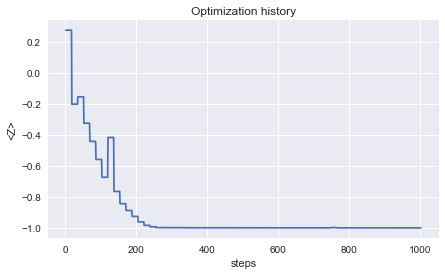

In [12]:
plt.style.use('seaborn')

fig = plt.figure(figsize=(7,4))

plt.plot(counts, values)

plt.title("Optimization history")
plt.ylabel("<Z>")
plt.xlabel("steps");

Try to substitute the optimized parameters in the circuit 

In [13]:
res_dict = result['optimal_parameters']

# Assign the values in the circuit
qc_full = qc_wx.assign_parameters(res_dict)
# qca.measure_all()
qc_full.draw()

qasm_bknd = qk.Aer.get_backend("statevector_simulator")
counts = qk.execute(qc_full, backend = qasm_bknd, shots = 1000).result().get_counts()
print(counts)

{'0000': 0.161542027651742, '0001': 0.134317090703182, '0010': 0.12853996719763, '0011': 0.155224253207073, '0100': 0.094888366022374, '0101': 0.121333308307576, '0110': 0.115807356341882, '0111': 0.088342302072848, '1000': 7.79699415e-07, '1001': 5.61950349e-07, '1010': 7.58064414e-07, '1011': 5.29966568e-07, '1100': 1.022667745e-06, '1101': 4.08647127e-07, '1110': 5.56395098e-07, '1111': 7.11104976e-07}


The first qubit (the leftmost) is actually always in zero, correctly! The mean value of $\langle Z \rangle$ is given by

In [14]:
x = np.array(list(counts.values()))

# mZ = number of times is '0' - number of times is '1'
mZ = np.sum(x[0:8])-np.sum(x[8:16])

print("<Z> = ", mZ)

<Z> =  0.999989343008615


## Using Torch Connector

In [469]:
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.opflow import AerPauliExpectation


from torch import Tensor
import torch
from torch.nn import MSELoss
from torch.optim import LBFGS, SGD, Adam, RMSprop

In [470]:
qi_qasm = QuantumInstance(Aer.get_backend('qasm_simulator'))
qi = QuantumInstance(Aer.get_backend('statevector_simulator'))

qnn = CircuitQNN(qc, input_params=X, weight_params=params, 
                 quantum_instance = qi, exp_val = AerPauliExpectation)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn.num_weights) - 1)
model = TorchConnector(qnn, initial_weights)

TypeError: __init__() got an unexpected keyword argument 'exp_val'

How to evaluate the model

In [113]:
# Pick some random inputs and turn them to a Torch Tensor
# random_x = np.random.rand(len(inputs))
random_x = np.array([0.5,0.5,0.5,0.5])
tr_x = Tensor(random_x)

# Call the model
print("Output to a single input:\n", model(tr_x))
print(f"len(model(tr_x)) = {len(model(tr_x))}")

# Note that you can batch multiple (set of) inputs!
batch_size = 3
random_x = np.stack((random_x,) * 3, axis=0)
tr_x = Tensor(random_x)

print("\nOutput to a batch of inputs:\n", model(tr_x))

Output to a single input:
 tensor([0.6336, 0.0231, 0.0234, 0.0086, 0.0123, 0.0402, 0.0122, 0.0391, 0.0111,
        0.0122, 0.0414, 0.0396, 0.0264, 0.0257, 0.0260, 0.0251],
       grad_fn=<_TorchNNFunctionBackward>)
len(model(tr_x)) = 16

Output to a batch of inputs:
 tensor([[0.6336, 0.0231, 0.0234, 0.0086, 0.0123, 0.0402, 0.0122, 0.0391, 0.0111,
         0.0122, 0.0414, 0.0396, 0.0264, 0.0257, 0.0260, 0.0251],
        [0.6336, 0.0231, 0.0234, 0.0086, 0.0123, 0.0402, 0.0122, 0.0391, 0.0111,
         0.0122, 0.0414, 0.0396, 0.0264, 0.0257, 0.0260, 0.0251],
        [0.6336, 0.0231, 0.0234, 0.0086, 0.0123, 0.0402, 0.0122, 0.0391, 0.0111,
         0.0122, 0.0414, 0.0396, 0.0264, 0.0257, 0.0260, 0.0251]],
       grad_fn=<_TorchNNFunctionBackward>)


In [114]:
total_dict = {**{X[i]: random_x[1,i] for i in range(len(random_x[1]))},
              **{params[i]: initial_weights[i] for i in range(len(initial_weights))}}
new_qc = qc.assign_parameters(total_dict)

qk.execute(new_qc, backend = qk.Aer.get_backend('statevector_simulator')).result().get_statevector()

array([ 0.78755485+0.11575246j, -0.14848257+0.03279187j,
       -0.14401941+0.05187965j, -0.08457281+0.03794129j,
       -0.08641243+0.0695431j , -0.12313959-0.15831756j,
       -0.08867652+0.06585505j, -0.08408091-0.17885766j,
       -0.08979064+0.05527846j, -0.08436996+0.07104977j,
       -0.11304452-0.16928119j, -0.10509885-0.16890517j,
       -0.01197382-0.1619476j , -0.02536604-0.15829987j,
       -0.00968924-0.16096053j,  0.00315615-0.15824277j])

### Training

In [202]:
num_samples = 20

random_x = np.random.rand(len(inputs))
x_training = Tensor(np.stack((random_x,) * num_samples, axis=0))

y = Tensor(np.stack(([1.]+[0.]*15,) * num_samples, axis = 0))

#### With Adam, or else

In [313]:
# define model, optimizer, and loss
optimizer = Adam(model.parameters(), lr = 0.001)
f_loss = MSELoss(reduction = "sum")

In [241]:
9.9928e-02 * 20

1.9985600000000001

In [302]:
x_training[1]

tensor([0.8074, 0.8961, 0.3180, 0.1101])

In [310]:
luca = Tensor([[0.8074, 0.8961, 0.3180, 0.1101]])
lullo = Tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [334]:
Tensor([1,2,3])[0]

tensor(1.)

In [342]:
print(len(Tensor([1,2,3,4]).shape))
model(Tensor([1,2,3,4]))

1


tensor([3.4291e-04, 1.0865e-01, 3.0298e-02, 1.5424e-01, 1.2212e-04, 4.8808e-02,
        1.8810e-01, 6.2998e-02, 6.9152e-02, 1.0246e-01, 1.8689e-03, 9.6349e-02,
        4.8438e-02, 4.5665e-02, 2.7615e-03, 3.9745e-02],
       grad_fn=<_TorchNNFunctionBackward>)

In [356]:
model(Tensor([[1,2,3,4],[1,2,3,4],[1,2,3,4]]))

tensor([[3.4291e-04, 1.0865e-01, 3.0298e-02, 1.5424e-01, 1.2212e-04, 4.8808e-02,
         1.8810e-01, 6.2998e-02, 6.9152e-02, 1.0246e-01, 1.8689e-03, 9.6349e-02,
         4.8438e-02, 4.5665e-02, 2.7615e-03, 3.9745e-02],
        [3.4291e-04, 1.0865e-01, 3.0298e-02, 1.5424e-01, 1.2212e-04, 4.8808e-02,
         1.8810e-01, 6.2998e-02, 6.9152e-02, 1.0246e-01, 1.8689e-03, 9.6349e-02,
         4.8438e-02, 4.5665e-02, 2.7615e-03, 3.9745e-02],
        [3.4291e-04, 1.0865e-01, 3.0298e-02, 1.5424e-01, 1.2212e-04, 4.8808e-02,
         1.8810e-01, 6.2998e-02, 6.9152e-02, 1.0246e-01, 1.8689e-03, 9.6349e-02,
         4.8438e-02, 4.5665e-02, 2.7615e-03, 3.9745e-02]],
       grad_fn=<_TorchNNFunctionBackward>)

In [387]:
s = model(Tensor([[1,2,3,4],[1,2,3,4],[1,2,3,4]])).sum()
model.zero_grad()
s.backward()
print(s)
uno = model.weights.grad.clone()
print(uno)

tensor(3., grad_fn=<SumBackward0>)
tensor([-8.9407e-07, -2.3842e-07, -4.7684e-07,  0.0000e+00,  6.5565e-07,
         9.5367e-07,  1.7881e-07,  4.7684e-07,  0.0000e+00,  2.3842e-07,
         0.0000e+00,  1.7881e-07,  4.6141e-15, -4.1763e-16,  2.6678e-15,
        -9.2504e-16])


In [395]:
s = torch.mul(model(Tensor([1,2,3,4])).sum(), 3)
model.zero_grad()
s.backward()
print(s)
due = model.weights.grad
print(due)

tensor(3., grad_fn=<MulBackward0>)
tensor([-2.4214e-08,  0.0000e+00, -1.4901e-08,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  2.2352e-08,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  2.8838e-16, -2.6102e-17,  1.6674e-16,
        -5.7815e-17])


In [465]:
a = torch.tensor(2., requires_grad = True)
b = torch.cos(a)
c = 2 * b
c.backward()
print(a, b, c, f)
print("grad =", a.grad)

tensor(2., requires_grad=True) tensor(-0.4161, grad_fn=<CosBackward>) tensor(-0.8323, grad_fn=<MulBackward0>) tensor(-0.8323, grad_fn=<SumBackward0>)
grad = tensor(-1.8186)


In [458]:
a = torch.tensor([2., 2.], requires_grad = True)
f = torch.cos(a).sum()
f.backward()
print(a, b, f)
print("grad =", a.grad)

tensor([2., 2.], requires_grad=True) tensor(-0.4161, grad_fn=<CosBackward>) tensor(-0.8323, grad_fn=<SumBackward0>)
grad = tensor([-0.9093, -0.9093])


In [441]:
np.cos(3*2)

0.9601702866503661

In [393]:
-2.4214e-08 / -3.7253e-09

6.499879204359381

In [460]:
model.train()

loss = 0.0                                        
          
output = model(x_training[1])                          
loss = f_loss(output, y[1])
print(output, loss)

print(len(x_training[1].shape) == 1)

optimizer.zero_grad()      
        
loss.backward()

print("before:", model._weights)
print("grad:", model._weights.grad)
print(loss)

#optimizer.step()

print("after:", model._weights)

tensor([4.9431e-01, 3.6245e-02, 5.9016e-03, 2.3781e-03, 4.0788e-02, 1.4005e-01,
        4.4673e-03, 3.0290e-04, 1.2541e-03, 5.2499e-03, 8.4571e-02, 2.2019e-02,
        9.0072e-03, 3.8864e-04, 8.3953e-02, 6.9113e-02],
       grad_fn=<_TorchNNFunctionBackward>) tensor(0.2979, grad_fn=<MseLossBackward>)
True
before: Parameter containing:
tensor([ 0.0815, -0.0501, -0.0179,  0.0511, -0.0542, -0.0846, -0.0420, -0.0678,
         0.0859,  0.0616,  0.0267,  0.0743,  0.0607, -0.0627,  0.0785,  0.0079],
       requires_grad=True)
grad: tensor([ 9.9928e-02,  7.3322e-02,  1.1955e-01, -6.3936e-03,  9.0407e-02,
         1.0371e-01,  3.9219e-02, -3.9475e-04, -1.0842e-01, -1.4568e-02,
         1.4905e-02,  1.2690e-02, -4.9963e-17, -2.5535e-17,  3.9277e-18,
         4.8238e-17])
tensor(0.2979, grad_fn=<MseLossBackward>)
after: Parameter containing:
tensor([ 0.0815, -0.0501, -0.0179,  0.0511, -0.0542, -0.0846, -0.0420, -0.0678,
         0.0859,  0.0616,  0.0267,  0.0743,  0.0607, -0.0627,  0.0785,  0.007

In [462]:
model.train()

# define model, optimizer, and loss
optimizer = Adam(model.parameters(), lr = 0.001)
f_loss = MSELoss(reduction = "sum")

loss = 0.0   

luca = Tensor([x_training[0].numpy()])
lullo = Tensor([y[0].numpy()])

print(len(luca.shape))
          
output = model(luca)                          
loss = f_loss(output, lullo)
print(output, loss)
        
optimizer.zero_grad()      
        
loss.backward()

print("before:", model._weights)
print("grad:", model._weights.grad)
print(loss)

#optimizer.step()

print("after:", model._weights)

2
tensor([[4.9431e-01, 3.6245e-02, 5.9016e-03, 2.3781e-03, 4.0788e-02, 1.4005e-01,
         4.4673e-03, 3.0290e-04, 1.2541e-03, 5.2499e-03, 8.4571e-02, 2.2019e-02,
         9.0072e-03, 3.8864e-04, 8.3953e-02, 6.9113e-02]],
       grad_fn=<_TorchNNFunctionBackward>) tensor(0.2979, grad_fn=<MseLossBackward>)
before: Parameter containing:
tensor([ 0.0815, -0.0501, -0.0179,  0.0511, -0.0542, -0.0846, -0.0420, -0.0678,
         0.0859,  0.0616,  0.0267,  0.0743,  0.0607, -0.0627,  0.0785,  0.0079],
       requires_grad=True)
grad: tensor([-5.5879e-09, -1.2107e-08,  9.3132e-09,  0.0000e+00,  1.3039e-08,
         2.7940e-09, -6.0536e-09, -7.6398e-11,  4.6566e-09, -2.5611e-09,
         0.0000e+00,  1.8626e-09, -6.6174e-24,  1.6544e-24,  1.2408e-24,
        -4.9631e-24])
tensor(0.2979, grad_fn=<MseLossBackward>)
after: Parameter containing:
tensor([ 0.0815, -0.0501, -0.0179,  0.0511, -0.0542, -0.0846, -0.0420, -0.0678,
         0.0859,  0.0616,  0.0267,  0.0743,  0.0607, -0.0627,  0.0785,  0.00

In [320]:
# define model, optimizer, and loss
optimizer = Adam(model.parameters(), lr = 0.001)
f_loss = MSELoss(reduction = "sum")

epochs = 1
for e in range(epochs):
    print(f"Epoch {e+1}\n-------------------------------")
    
    optimizer.zero_grad(set_to_none = True)

    loss1 = 0.0
    loss2 = 0.0
    for x_, y_target in zip(x_training, y):           
        output = model(x_)                            
        loss1 += f_loss(output, y_target)  
        loss2 += (output-y_target).pow(2).sum()
        
    loss1.backward()  
    
    print("before:", model._weights)
    print("grad:", model._weights.grad)
    print("loss1:", loss1)
    print("loss2:", loss2)
    
    print(loss1.item())                                
    #optimizer.step()

Epoch 1
-------------------------------
before: Parameter containing:
tensor([ 0.0815, -0.0501, -0.0179,  0.0511, -0.0542, -0.0846, -0.0420, -0.0678,
         0.0859,  0.0616,  0.0267,  0.0743,  0.0607, -0.0627,  0.0785,  0.0079],
       requires_grad=True)
grad: tensor([ 1.9986e+00,  1.4664e+00,  2.3911e+00, -1.2787e-01,  1.8081e+00,
         2.0742e+00,  7.8438e-01, -7.8949e-03, -2.1684e+00, -2.9136e-01,
         2.9809e-01,  2.5379e-01, -9.9926e-16, -5.1070e-16,  7.8554e-17,
         9.6475e-16])
loss1: tensor(5.9589, grad_fn=<AddBackward0>)
loss2: tensor(5.9589, grad_fn=<AddBackward0>)
5.958948612213135


In [243]:
# define model, optimizer, and loss
optimizer2 = Adam(model.parameters(), lr = 1)
f_loss = MSELoss(reduction = "sum")

In [321]:
inter = model(x_training)-y
loss = torch.sum(torch.pow(inter, 2))

print("X:", model(x_training))
print("Inter:", inter)
print("Loss:", loss)
     
optimizer.zero_grad()
loss.backward()

print("before:", model._weights)
print("grad:", model._weights.grad)
print(loss)

print(loss.item())                                
#optimizer2.step()

X: tensor([[4.9431e-01, 3.6245e-02, 5.9016e-03, 2.3781e-03, 4.0788e-02, 1.4005e-01,
         4.4673e-03, 3.0290e-04, 1.2541e-03, 5.2499e-03, 8.4571e-02, 2.2019e-02,
         9.0072e-03, 3.8864e-04, 8.3953e-02, 6.9113e-02],
        [4.9431e-01, 3.6245e-02, 5.9016e-03, 2.3781e-03, 4.0788e-02, 1.4005e-01,
         4.4673e-03, 3.0290e-04, 1.2541e-03, 5.2499e-03, 8.4571e-02, 2.2019e-02,
         9.0072e-03, 3.8864e-04, 8.3953e-02, 6.9113e-02],
        [4.9431e-01, 3.6245e-02, 5.9016e-03, 2.3781e-03, 4.0788e-02, 1.4005e-01,
         4.4673e-03, 3.0290e-04, 1.2541e-03, 5.2499e-03, 8.4571e-02, 2.2019e-02,
         9.0072e-03, 3.8864e-04, 8.3953e-02, 6.9113e-02],
        [4.9431e-01, 3.6245e-02, 5.9016e-03, 2.3781e-03, 4.0788e-02, 1.4005e-01,
         4.4673e-03, 3.0290e-04, 1.2541e-03, 5.2499e-03, 8.4571e-02, 2.2019e-02,
         9.0072e-03, 3.8864e-04, 8.3953e-02, 6.9113e-02],
        [4.9431e-01, 3.6245e-02, 5.9016e-03, 2.3781e-03, 4.0788e-02, 1.4005e-01,
         4.4673e-03, 3.0290e-04, 1.2

before: Parameter containing:
tensor([ 0.0815, -0.0501, -0.0179,  0.0511, -0.0542, -0.0846, -0.0420, -0.0678,
         0.0859,  0.0616,  0.0267,  0.0743,  0.0607, -0.0627,  0.0785,  0.0079],
       requires_grad=True)
grad: tensor([-2.6822e-07, -4.4703e-07,  7.1526e-07,  2.2352e-08,  1.4901e-07,
        -1.4901e-07,  2.2352e-08, -3.4051e-08, -3.4273e-07, -1.4901e-08,
         0.0000e+00, -1.1176e-07,  0.0000e+00, -5.2940e-23, -1.0588e-22,
         3.7058e-22])
tensor(5.9589, grad_fn=<SumBackward0>)
5.958949565887451


In [281]:
-5.3644 / -2.6822

2.0

In [295]:
torch.pow((output - y),2).sum() / 20

tensor(0.2979, grad_fn=<DivBackward0>)

In [301]:
# define model, optimizer, and loss
optimizer = SGD(model.parameters(), lr = 0.001)
f_loss = MSELoss(reduction = "none")

epochs = 1
for e in range(epochs):
    print(f"Epoch {e+1}\n-------------------------------")
                     
    optimizer.zero_grad()   
    
    output = model(x_training)                            
    loss = f_loss(output, y)
    print(loss.sum())
        
    loss.sum().backward()
    
    print("before:", model._weights)
    print("grad:", model._weights.grad)
    print(loss)
    
    print(loss.item())                                
    #optimizer.step()

Epoch 1
-------------------------------
tensor(5.9589, grad_fn=<SumBackward0>)
before: Parameter containing:
tensor([ 0.0815, -0.0501, -0.0179,  0.0511, -0.0542, -0.0846, -0.0420, -0.0678,
         0.0859,  0.0616,  0.0267,  0.0743,  0.0607, -0.0627,  0.0785,  0.0079],
       requires_grad=True)
grad: tensor([-2.6822e-07, -4.4703e-07,  7.1526e-07,  2.2352e-08,  1.4901e-07,
        -1.4901e-07,  2.2352e-08, -3.4051e-08, -3.4273e-07, -1.4901e-08,
         0.0000e+00, -1.1176e-07,  0.0000e+00, -5.2940e-23, -1.0588e-22,
         3.7058e-22])
tensor([[2.5572e-01, 1.3137e-03, 3.4829e-05, 5.6555e-06, 1.6636e-03, 1.9614e-02,
         1.9956e-05, 9.1748e-08, 1.5727e-06, 2.7561e-05, 7.1523e-03, 4.8482e-04,
         8.1130e-05, 1.5104e-07, 7.0480e-03, 4.7767e-03],
        [2.5572e-01, 1.3137e-03, 3.4829e-05, 5.6555e-06, 1.6636e-03, 1.9614e-02,
         1.9956e-05, 9.1748e-08, 1.5727e-06, 2.7561e-05, 7.1523e-03, 4.8482e-04,
         8.1130e-05, 1.5104e-07, 7.0480e-03, 4.7767e-03],
        [2.5572e

ValueError: only one element tensors can be converted to Python scalars

#### With LBGFS

In [181]:
# define model, optimizer, and loss
optimizer = LBFGS(model.parameters())
f_loss = MSELoss(reduction = "sum")

# start training
# model1.train()    
def closure():
    optimizer.zero_grad(set_to_none=True)                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x_, y_target in zip(x_training, y):                # evaluate batch loss
        output = model(x_)                                 # forward pass
        loss += f_loss(output, y_target)                   # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);

3.4872145652770996
3.0733790397644043
3.035243511199951
3.0075011253356934
2.9782538414001465
2.9462571144104004
2.9649910926818848
2.9355666637420654
2.9341938495635986
2.927816867828369
2.9214768409729004
2.9269697666168213
2.915386915206909
2.915128231048584
2.915034055709839
2.9149672985076904
2.914731979370117
2.9145889282226562
2.914599895477295
2.9145290851593018


In [ ]:
model

In [182]:
output = model(x_training)
loss = f_loss(output, y)
loss

tensor(2.9145, grad_fn=<MseLossBackward>)

In [183]:
loss = 0.0                                             # initialize loss    
for x_, y_target in zip(x_training, y):                # evaluate batch loss
    output = model(x_)                                 # forward pass
    loss += f_loss(output, y_target) 
loss

tensor(2.9145, grad_fn=<AddBackward0>)

In [198]:
# define model, optimizer, and loss
optimizer = LBFGS(model.parameters())
f_loss = MSELoss(reduction = "sum")

# start training
# model1.train()    
def closure():
    optimizer.zero_grad(set_to_none=True)            
    
    output = model(x_training)
    loss = f_loss(output, y)                 
        
    loss.backward()                                  
    
    print(loss.item())                               
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);

5.041742324829102


In [199]:
optimizer

LBFGS (
Parameter Group 0
    history_size: 100
    line_search_fn: None
    lr: 1
    max_eval: 25
    max_iter: 20
    tolerance_change: 1e-09
    tolerance_grad: 1e-07
)

In [188]:
optimizer.step(closure);

2.9145286083221436


tensor(2.9145, grad_fn=<MseLossBackward>)

In [41]:
model.summary()

AttributeError: 'TorchConnector' object has no attribute 'summary'

In [35]:
optimizer = SGD(model.parameters(), lr = 0.01, momentum = 0.9)

epochs = 5
for e in range(epochs):
    print(f"Epoch {e+1}\n-------------------------------")
    for i, (_x, _y) in enumerate(zip(x_training, y)):
        optimizer.zero_grad()
        # print(_x, model(Tensor(_x)), Tensor(_y))
        loss = f_loss(model(Tensor(_x)), Tensor(_y))
        loss.backward()
        optimizer.step()
        print(i, loss.item())

Epoch 1
-------------------------------
0 0.013601535931229591
1 0.01359959039837122
2 0.013595893047749996
3 0.013590622693300247
4 0.013583943247795105
5 0.013576005585491657
6 0.013566937297582626
7 0.013556858524680138
8 0.01354588195681572
9 0.013534107245504856
10 0.013521615415811539
11 0.013508499599993229
12 0.013494819402694702
13 0.013480649329721928
14 0.013466046191751957
15 0.013451062142848969
16 0.013435745611786842
17 0.01342013943940401
18 0.013404285535216331
19 0.01338821742683649
Epoch 2
-------------------------------
0 0.013371963053941727
1 0.013355555012822151
2 0.013339015655219555
3 0.013322371989488602
4 0.013305643573403358
5 0.013288845308125019
6 0.013271997682750225
7 0.013255114667117596
8 0.01323821023106575
9 0.013221291825175285
10 0.01320437528192997
11 0.013187470845878124
12 0.013170584104955196
13 0.013153722509741783
14 0.013136898167431355
15 0.013120108284056187
16 0.01310336496680975
17 0.013086672872304916
18 0.013070031069219112
19 0.013053

In [470]:
f_loss(model(Tensor(x_training)), Tensor(y))

tensor(0.0010, grad_fn=<MseLossBackward>)

In [444]:
model(Tensor(x_training[1]))

tensor([6.3255e-01, 4.4089e-04, 5.7305e-03, 1.9850e-04, 3.4402e-04, 1.0417e-01,
        5.0088e-04, 6.9941e-03, 2.3916e-04, 1.3964e-02, 4.4342e-04, 1.1650e-01,
        7.5398e-02, 8.8017e-04, 4.1416e-02, 2.3349e-04],
       grad_fn=<_TorchNNFunctionBackward>)

In [153]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit  import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

qi = QuantumInstance(Aer.get_backend('statevector_simulator'))

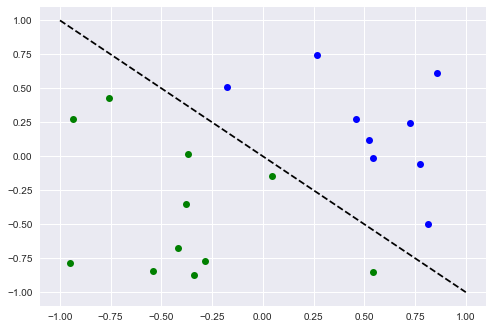

In [154]:
num_inputs = 2
num_samples = 20
X = 2*np.random.rand(num_samples, num_inputs) - 1
y01 = 1*(np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2*y01-1                       # in {-1, +1}

X_ = Tensor(X)
y01_ = Tensor(y01).reshape(len(y)).long()
y_ = Tensor(y).reshape(len(y), 1)

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

In [155]:
# set up QNN
qnn1 = TwoLayerQNN(num_qubits=num_inputs, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn1.num_weights) - 1)
model1 = TorchConnector(qnn1, initial_weights=initial_weights)

In [156]:
# define optimizer and loss
optimizer = LBFGS(model1.parameters())
f_loss = MSELoss(reduction='sum')

# start training
model1.train()   # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()          # initialize gradient
    loss = f_loss(model1(X_), y_)  # evaluate loss function
    loss.backward()                # backward pass
    print(loss.item())             # print loss
    return loss

# run optimizer
optimizer.step(closure)

29.21783447265625
24.286067962646484
26.82376480102539
18.97518539428711
30.349735260009766
20.120182037353516
19.831050872802734


KeyboardInterrupt: 

Accuracy: 0.7


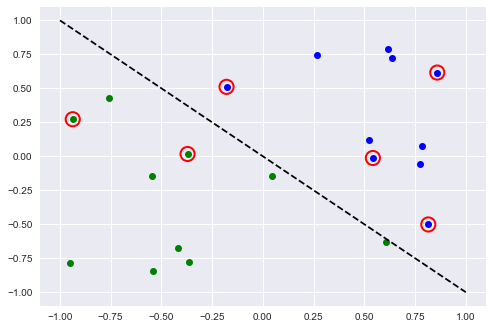

In [47]:
# evaluate model and compute accuracy
y_predict = []
for x, y_target in zip(X, y):
    output = model1(Tensor(x))
    y_predict += [np.sign(output.detach().numpy())[0]]

print('Accuracy:', sum(y_predict == y)/len(y))

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()